In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import glob
import tqdm
import time
import yaml
import h5py
import scipy
import torch
import pickle
import joblib
import random
import sklearn
import logging
import datetime
import torch.fft
import torchvision
import torchvision.models as models

#torch.multiprocessing.set_start_method('spawn')

import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from collections import defaultdict
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple

from scipy.sparse import csr_matrix
from colour import Color

import multiprocessing as mp

In [ ]:
%matplotlib inline

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

In [46]:
# Dice similarity function

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    
    if intersection == 0.0:
        return 1.0
    
    smooth = 0.0001
    result = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
    return result.item()

def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union == 0: 
        return 1.0
    smooth = 0.0001
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (smooth + union)

In [5]:
def save_sparse_csr(filename, array):
    # note that .npz extension is added automatically
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

In [6]:
class ResNet(nn.Module):
    def __init__(self, fcl_layers = [], dr = 0.0, output_size = 1, resnet_model = 18, pretrained = True):
        super(ResNet, self).__init__()
        self.pretrained = pretrained
        self.resnet_model = resnet_model 
        if self.resnet_model == 18:
            resnet = models.resnet18(pretrained=self.pretrained)
        elif self.resnet_model == 34:
            resnet = models.resnet34(pretrained=self.pretrained)
        elif self.resnet_model == 50:
            resnet = models.resnet50(pretrained=self.pretrained)
        elif self.resnet_model == 101:
            resnet = models.resnet101(pretrained=self.pretrained)
        elif self.resnet_model == 152:
            resnet = models.resnet152(pretrained=self.pretrained)
        resnet.conv1 = torch.nn.Conv1d(2, 64, (7, 7), (2, 2), (3, 3), bias=False) # Manually change color dim to match our data
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_output_dim = resnet.fc.in_features
        self.resnet = nn.Sequential(*modules)
        self.fcn = self.make_fcn(self.resnet_output_dim, output_size, fcl_layers, dr)
        
    def make_fcn(self, input_size, output_size, fcl_layers, dr):
        if len(fcl_layers) > 0:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, fcl_layers[0]),
                nn.BatchNorm1d(fcl_layers[0]),
                torch.nn.LeakyReLU()
            ]
            if len(fcl_layers) == 1:
                fcn.append(nn.Linear(fcl_layers[0], output_size))
            else:
                for i in range(len(fcl_layers)-1):
                    fcn += [
                        nn.Linear(fcl_layers[i], fcl_layers[i+1]),
                        nn.BatchNorm1d(fcl_layers[i+1]),
                        torch.nn.LeakyReLU(),
                        nn.Dropout(dr)
                    ]
                fcn.append(nn.Linear(fcl_layers[i+1], output_size))
        else:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, output_size)
            ]
        if output_size > 1:
            fcn.append(torch.nn.LogSoftmax(dim=1))
        return nn.Sequential(*fcn)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fcn(x)
        return x

In [7]:
class InferencePropagator:
    
    def __init__(self, 
                 data_path,
                 n_bins = 1000, 
                 tile_size = 512, 
                 step_size = 128, 
                 marker_size = 10, 
                 model = None,
                 device = "cuda"):
        
        self.h_ds = xr.open_dataset(data_path)
        self.n_bins = n_bins
        self.z_bins = np.linspace(self.h_ds.attrs['zMin'],self.h_ds.attrs['zMax'], n_bins+1)*1e6  # histogram bin edges
        self.z_centers = self.z_bins[:-1] + 0.5*np.diff(self.z_bins)  # histogram bin centers

        self.tile_size = tile_size  # size of tiled images in pixels
        self.step_size = step_size  # amount that we shift the tile to make a new tile
        self.marker_size = marker_size # UNET gaussian marker width (standard deviation) in um
        self.device = device

        # step_size is not allowed be be larger than the tile_size
        assert self.tile_size >= self.step_size

        self.dx = self.h_ds.attrs['dx']      # horizontal resolution
        self.dy = self.h_ds.attrs['dy']      # vertical resolution
        self.Nx = int(self.h_ds.attrs['Nx']) # number of horizontal pixels
        self.Ny = int(self.h_ds.attrs['Ny']) # number of vertical pixels
        self.lam = self.h_ds.attrs['lambda'] # wavelength
        self.zMin = self.h_ds.attrs['zMin']  # minimum z in sample volume
        self.zMax = self.h_ds.attrs['zMax'] 
        self.image_norm = 255.0

        self.x_arr = np.arange(-self.Nx//2, self.Nx//2)*self.dx
        self.y_arr = np.arange(-self.Ny//2, self.Ny//2)*self.dy
        
        self.tile_x_bins = np.arange(-self.Nx//2,self.Nx//2,self.step_size)*self.dx*1e6
        self.tile_y_bins = np.arange(-self.Ny//2,self.Ny//2,self.step_size)*self.dy*1e6
        
        self.fx = None
        self.fy = None
        self.model = model

    
    def compute_f(self):
        self.fx = torch.fft.fftfreq(self.Nx,self.dx,device=self.device).unsqueeze(0).unsqueeze(2)
        self.fy = torch.fft.fftfreq(self.Ny,self.dy,device=self.device).unsqueeze(0).unsqueeze(1)
        
    
    def torch_holo_set(self, 
                       Ein: torch.tensor,
                       z_tnsr: torch.tensor):
        """
        Propagates an electric field a distance z
        Ein complex torch.tensor
        - input electric field

        fx:real torch.tensor
        - x frequency axis (3D, setup to broadcast)

        fy: real torch.tensor
        - y frequency axis (3D, setup to broadcast)

        z_tnsr: torch.tensor
        - tensor of distances to propagate the wave Ein
            expected to have dims (Nz,1,1) where Nz is the number of z
            dimensions

        lam: float
        - wavelength

        returns: complex torch.tensor with dims (Nz,fy,fx)

        Note the torch.fft library uses dtype=torch.complex64
        This may be an issue for GPU implementation

        """
        if self.fx is None:
            self.compute_f()
        
        Etfft = torch.fft.fft2(Ein)
        Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/self.lam*torch.sqrt(1-self.lam**2*(self.fx**2+self.fy**2)))

        # It might be helpful if we could omit this step.  It would save an inverse fft.
        Eout = torch.fft.ifft2(Eofft)

        return Eout
    
    
    def get_sub_images_labeled(self,image_tnsr,z_sub_set,z_counter, xp, yp, zp, dp, infocus_mask, z_part_bin_idx):
        """
        Reconstruct z_sub_set planes from
        the original hologram image and
        split it into tiles of size
        tile_size

        image - 3D tensor on device to reconstruct
        z_sub_set - array of z planes to reconstruct in one batch
        z_counter - counter of how many z images have been reconstructed

        Returns 
            Esub - a list of complex tiled images 
            image_index_lst - tile index of the sub image (x,y,z)
            image_corner_coords - x,y coordinates of the tile corner (starting values)
            z_pos - the z position of the plane in m
        """
        # build the torch tensor for reconstruction
        z_plane = torch.tensor(z_sub_set*1e-6,device=self.device).unsqueeze(-1).unsqueeze(-1)

        # reconstruct the selected planes
        E_out = self.torch_holo_set(image_tnsr,z_plane)

        image = torch.abs(E_out).unsqueeze(1)
        phase = torch.angle(E_out).unsqueeze(1)
        stacked_image = torch.cat([
            torch.abs(E_out).unsqueeze(1), torch.angle(E_out).unsqueeze(1)], 1)
        
        size = (E_out.shape[1], E_out.shape[2])
        true_label = torch.zeros(size).to(device)
        pred_label = torch.zeros(size).to(device)
        pred_proba = torch.zeros(size).to(device)
        counter = torch.zeros(size).to(device)
        
        results_dict = defaultdict(list)

        for z_idx in range(E_out.shape[0]):
            part_in_plane_idx = np.where(z_part_bin_idx==z_idx+z_counter)[0]  # locate all particles in this plane
            for row_idx in range(0,E_out.shape[1]//self.step_size):
                
                if row_idx*self.step_size+self.tile_size > E_out.shape[1]:
                    image_pixel_x = E_out.shape[1]-self.tile_size
                    row_slice = slice(-self.tile_size,None)
                    row_break = True
                else:
                    image_pixel_x = row_idx*self.step_size
                    row_slice = slice(row_idx*self.step_size,row_idx*self.step_size+self.tile_size)
                    row_break = False

                for col_idx in range(0,E_out.shape[2]//step_size):
                    if col_idx*self.step_size+self.tile_size > E_out.shape[2]:
                        image_pixel_y = E_out.shape[2]-self.tile_size
                        col_slice = slice(-self.tile_size,None)
                        col_break = True
                    else:
                        image_pixel_y = col_idx*self.step_size
                        col_slice = slice(col_idx*self.step_size,col_idx*self.step_size+self.tile_size)
                        col_break = False
                        
                    pred_logits = self.model(
                        stacked_image[z_idx, :, row_slice, col_slice].unsqueeze(0).float()
                    )
                    pred_probs, pred_labels = torch.max(pred_logits, 1)
                    pred_probs = pred_probs.exp()
                    pred_labels = pred_labels.squeeze(-1)
                    
                    if pred_labels.item() == 0:
                        pred_probs = 1.0 - pred_probs
                                        
                    label = int(infocus_mask[row_idx, col_idx, z_idx+z_counter])
                    true_labels = torch.LongTensor([label]).to(device)
                    
                    acc = true_labels == pred_labels
                    results_dict["acc"].append(acc)
                                    
                    counter[row_slice, col_slice] += 1
                    true_label[row_slice, col_slice] += true_labels
                    pred_label[row_slice, col_slice] += pred_labels
                    pred_proba[row_slice, col_slice] += pred_probs
                    
                    if E_out[z_idx, row_slice, col_slice].shape != (self.tile_size, self.tile_size):
                        print(f"Incorrect image size in tile: {E_out.shape} ")
    
                    if col_break: 
                        break

                if row_break:
                    break
                    
        pred_label = pred_label / counter
        pred_proba = pred_proba / counter
        true_label = true_label / counter        
        ave_acc = [x.detach().cpu().numpy()[0] for x in results_dict["acc"]]
        
        _pred_label = pred_label == 1.0
        _true_label = true_label == 1.0
        
        dice_0 = dice_coef(_pred_label, _true_label)
        #dice_0 = dice(_pred_label, _true_label, k = 0.0).item()
        #dice_1 = dice(_pred_label, _true_label, k = 1.0).item()
        
        return_dict = {
            "pred_label": pred_label.detach().cpu().numpy(),
            "pred_proba": pred_proba.detach().cpu().numpy(),
            "true_label": true_label.detach().cpu().numpy(),
            #"counter": counter,
            "acc": np.mean(ave_acc),
            "z_plane": z_sub_set[z_idx],
            "dice": dice_0
        }
                    
        return return_dict
        
            
    def get_next_z_planes_labeled(self, h_idx, z_planes_lst):
        """
        Generator that returns reconstructed z patches
        input_image - 2D image array of the original captured hologam 
        z_planes_lst - list containing batchs of arrays of z positions to reconstruct
            create_z_plane_lst() will provide this for a desired batch size and set
            planes

        returns:
            sub_image - list of sub images
            image_index_lst - list of tile indicies to the sub image
            image_coords - x,y corner coordinates of the sub images
            image_z - z location of the sub image in m
        """

        # locate particle information corresponding to this hologram
        particle_idx = np.where(self.h_ds['hid'].values==h_idx+1)

        x_part = self.h_ds['x'].values[particle_idx]
        y_part = self.h_ds['y'].values[particle_idx]
        z_part = self.h_ds['z'].values[particle_idx]
        d_part = self.h_ds['d'].values[particle_idx]  # not used but here it is

        # create a 3D histogram 
        in_data = np.stack((x_part, y_part, z_part)).T
        h_part = np.histogramdd(in_data,bins=[self.tile_x_bins,self.tile_y_bins,self.z_bins])[0]
        z_part_bin_idx = np.digitize(z_part, self.z_bins)-1 # specify the z bin locations of the particles

        # smoothing kernel accounts for overlapping subimages when the 
        # subimage is larger than the stride
        if self.step_size < self.tile_size:
            overlap_kernel = np.ones((
                self.tile_size//self.step_size,self.tile_size//self.step_size
            ))
            for z_idx in range(h_part.shape[-1]):
                b = self.tile_size//self.step_size
                h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[b-1:h_part.shape[0]+b-1,b-1:h_part.shape[1]+b-1]

        input_image = self.h_ds['image'].isel(hologram_number=h_idx).values

        z_counter = 0 # the number of planes reconstructed in this generator
        image_tnsr = torch.tensor(input_image, device=self.device).unsqueeze(0)
        for z_sub_set in z_planes_lst:
            yield self.get_sub_images_labeled(image_tnsr, z_sub_set, z_counter, x_part, y_part, z_part, d_part, h_part, z_part_bin_idx)
            z_counter+=z_sub_set.size
            
            
    def create_z_plane_lst(self, planes_per_call=1):
        """
        Create a list of z planes according to the requested
        batch size.  This generates the z_planes_lst argument
        needed for gen_next_z_plane()
        """
        z_lst = []
        for z_idx in np.arange(0, self.z_centers.size, planes_per_call):
            z_lst.append(self.z_centers[z_idx:(z_idx+planes_per_call)])
        return z_lst

In [8]:
synthetic_path = "/data/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc"

n_bins = 1000  # number of bins in histogram
tile_size = 512  # size of tiled images in pixels
step_size = 128  # amount that we shift the tile to make a new tile
marker_size = 10 # UNET gaussian marker width (standard deviation) in um

There are 11174402 total model parameters


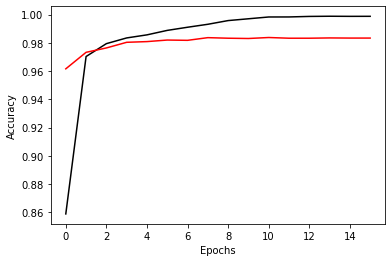

In [9]:
# Load a model

model_loc = "/data/schreck/holodec/reader/resnet18"

f = pd.read_csv(f"{model_loc}/training_log_resnet.csv")
plt.plot(f["epoch"], f["train_accuracy"], c = 'k')
plt.plot(f["epoch"], f["valid_accuracy"], c = 'r')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fcl_layers = []
dropout = 0.2
output_size = 2
resnet_model = 18
pretrained = True

model = ResNet(fcl_layers, 
               dr = dropout, 
               output_size = output_size, 
               resnet_model=resnet_model, 
               pretrained = pretrained).to(device)


checkpoint = torch.load(
    f"{model_loc}/best_resnet.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"There are {total_params} total model parameters")

In [10]:
prop = InferencePropagator(
    synthetic_path, 
    n_bins = n_bins,
    tile_size = tile_size,
    step_size = step_size,
    marker_size = marker_size,
    model = model,
    device = device
)

In [11]:
h_idx = 10
test_image = prop.h_ds['image'].isel(hologram_number=h_idx)

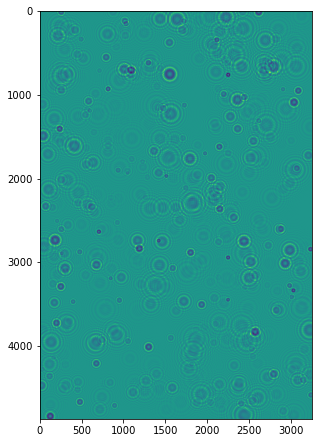

In [12]:
shape = test_image.values.shape
ratio = shape[0] / shape[1]

plt.figure(figsize = (5, 5 * ratio))
plt.imshow(test_image.values)

### Create a list of z-values to propagate to

In [13]:
z_list = prop.create_z_plane_lst(planes_per_call=1)

### Initialize the generator

In [14]:
inference_generator = prop.get_next_z_planes_labeled(h_idx, z_list)

### Main loop to call the generator, predict with the model, and aggregate and save the results

In [14]:
plot = False

model.eval()
with torch.no_grad():
    
    jiter = tqdm.tqdm(
        enumerate(inference_generator), 
        total = len(z_list), 
        leave=True
    )
    
    dice0 = []
    total_accuracy = []
    for z_idx, results_dict in jiter:
        
        # Get stuff from the results dictionary
        pred_label = results_dict["pred_label"]
        pred_prob = results_dict["pred_proba"]
        true_label = results_dict["true_label"]
        acc = results_dict["acc"]
        z_plane = int(results_dict["z_plane"])
        dice = results_dict["dice"]
        
        # Save the giant matrices as sparse arrays, as most elements are zero
        save_sparse_csr(f"images/prob_{z_plane}.npz", scipy.sparse.csr_matrix(pred_prob))
        
        pred_label = pred_label == 1.0
        save_sparse_csr(f"images/pred_{z_plane}.npz", scipy.sparse.csr_matrix(pred_label))
        
        true_label = true_label == 1.0
        save_sparse_csr(f"images/true_{z_plane}.npz", scipy.sparse.csr_matrix(true_label))
        
        # Update any metrics you want printed to screen
        dice0.append(dice)
        total_accuracy.append(acc)
        to_print = f"Plane: {z_idx} at z: {z_plane*1e-6} plane_acc: {acc:.6f} holo_acc: {np.mean(total_accuracy):.6f}"
        to_print += f" holo_dice: {np.mean(dice0):.6f}"
        jiter.set_description(to_print)
        jiter.update()
        
        # Option to plot each result per plane
        if plot:
            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
            p1 = ax0.imshow(pred_prob, vmin = 0,  vmax = 1)
            ax0.set_title("In-focus confidence")
            fig.colorbar(p1, ax=ax0)

            p2 = ax1.imshow(pred_label, vmin = 0,  vmax = 1)
            ax1.set_title("Predicted particles")
            fig.colorbar(p2, ax=ax1)

            p3 = ax2.imshow(true_label, vmin = 0, vmax = 1)
            ax2.set_title("True particles")
            fig.colorbar(p3, ax=ax2)

            plt.tight_layout()
            plt.show()

Plane: 999 at z: 0.15792799999999999 plane_acc: 0.980676 holo_acc: 0.981501 holo_dice_0: 0.879011: 100%|██████████| 1000/1000 [1:26:47<00:00,  5.21s/it]


### Load the data from saved location

In [25]:
# for z_idx in range(50):

#     pred_prob = load_sparse_csr(f"images/prob_{z_idx}")
#     pred_label = load_sparse_csr(f"images/pred_{z_idx}")
#     true_label = load_sparse_csr(f"images/true_{z_idx}")

#     fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
#     p1 = ax0.imshow(pred_prob.toarray(), vmin = 0,  vmax = 1)
#     ax0.set_title("In-focus confidence")
#     fig.colorbar(p1, ax=ax0)

#     _pred_label = pred_label == 1.0
#     p2 = ax1.imshow(_pred_label.toarray(), vmin = 0,  vmax = 1)
#     ax1.set_title("Predicted particles")
#     fig.colorbar(p2, ax=ax1)

#     _true_label = true_label == 1.0
#     p3 = ax2.imshow(_true_label.toarray(), vmin = 0, vmax = 1)
#     ax2.set_title("True particles")
#     fig.colorbar(p3, ax=ax2)

#     plt.tight_layout()
#     plt.show()

In [18]:
z_file_indices = sorted([int(x.replace(".npz", "").split("_")[1]) for x in glob.glob("images/true_*")])

In [19]:
red = Color("red")
red_white = list(map(str, red.range_to(Color("white"), 100)))[::-1]
color_range = np.array([x / 100 for x in list(range(100))])

In [107]:
def read_one_plane(z_idx):
    
    colors = []
    x, y, z = [], [], []
    xt, yt, zt = [], [], []

    # Load from sparse 
    pred_prob = load_sparse_csr(f"images/prob_{z_idx}")
    pred_label = load_sparse_csr(f"images/pred_{z_idx}")
    true_label = load_sparse_csr(f"images/true_{z_idx}")
    
    # Convert
    _pred_prob = pred_prob.toarray()
    _pred_label = (pred_label == 1.0).toarray()
    _true_label = (true_label == 1.0).toarray()
    
    # Compute some metrics
    #dice_score = dice_coef(_pred_label, _true_label)
    #dice_score_1 = dice(_pred_label, _true_label, k = 0.0)
    # TP, FP, TN, FN = sklearn.metrics.classification_report()
    
    condition1 = np.where(_pred_label)
    condition2 = np.where(_true_label)
    
    if len(condition1[0]) > 0:
        x += list(condition1[0])
        y += list(condition1[1])
        z += [z_idx for g in range(len(condition1[0]))]
        colors += [red_white[np.abs(color_range - _pred_prob[r][c]).argmin()] for r,c in zip(*condition1)]

    if len(condition2[0]) > 0:
        xt += list(condition2[0])
        yt += list(condition2[1])
        zt += [z_idx for g in range(len(condition2[0]))] 
        
    results = {
        "preds": [x, y, z, colors],
        "truths": [xt, yt, zt],
        "metrics": []
    }
        
    return results

In [108]:
colors = []
X, Y, Z = [], [], []
Xt, Yt, Zt = [], [], []

max_planes = 1000


ncpus = 8

with mp.Pool(ncpus) as p:
    
    for results in tqdm.tqdm(p.imap(read_one_plane, z_file_indices[:max_planes]), total = max_planes):

        X += results["preds"][0]
        Y += results["preds"][1]
        Z += results["preds"][2]
        colors += results["preds"][3]

        Xt += results["truths"][0]
        Yt += results["truths"][1]
        Zt += results["truths"][2]

100%|██████████| 1000/1000 [07:23<00:00,  2.25it/s]


(14072.0, 28327.0)

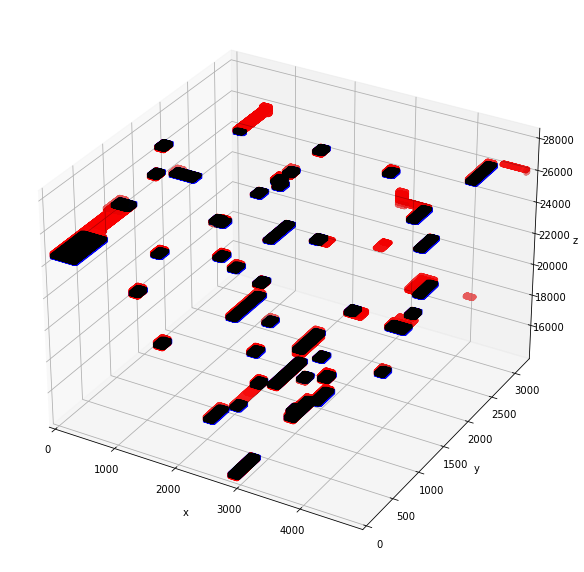

In [66]:
fig = plt.figure(figsize = (10, 14))
ax = plt.axes(projection ="3d")

maxn = 100

ax.scatter3D(X[:maxn], Y[:maxn], Z[:maxn], c = colors, alpha = 0.005, zorder = 1, marker = 'o') 
ax.scatter3D(Xt[:maxn], Yt[:maxn], Zt[:maxn], c = 'b', alpha = 0.005, zorder = 1, marker = 's')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim([0, 4872])
ax.set_ylim([0, 3248])
ax.set_zlim([z_file_indices[0], z_file_indices[max_planes-1]])

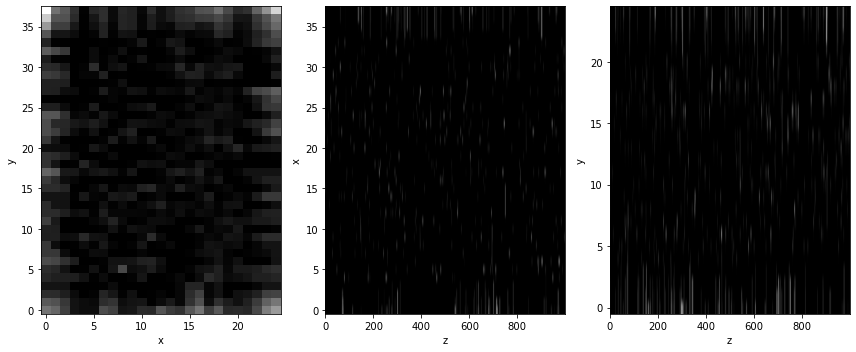

In [117]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))

hist, binx, biny = np.histogram2d(X, Y, bins = (test_image.shape[0] // step_size, test_image.shape[1] // step_size))
#x = np.linspace(min(X), max(X), hist.shape[0])
#y = np.linspace(min(Y), max(Y), hist.shape[1])
#x, y = np.meshgrid(x, y)
#ax0.contour(x, y, hist, zdir='z', offset=-3.)
ax0.imshow(hist, origin = "lower", aspect='auto', cmap='gist_gray')
ax0.set_xlabel("x")
ax0.set_ylabel("y")

histxz, binx, binz = np.histogram2d(X, Z, bins = (test_image.shape[0] // step_size, 1000))
#x = np.linspace(min(X), max(X), hist.shape[0])
#z = np.linspace(min(Z), max(Z), hist.shape[1])
#x, z = np.meshgrid(x, z)
ax1.imshow(histxz, origin = "lower", aspect='auto', cmap='gist_gray')
ax1.set_xlabel("z")
ax1.set_ylabel("x")

histyz, biny, binz = np.histogram2d(Y, Z, bins = (test_image.shape[1] // step_size, 1000))
#y = np.linspace(min(Y), max(Y), hist.shape[1])
#z = np.linspace(min(Z), max(Z), hist.shape[1])
#z, y = np.meshgrid(z, y)
ax2.imshow(histyz, origin = "lower", aspect='auto', cmap='gist_gray')
ax2.set_xlabel("z")
ax2.set_ylabel("y")

plt.tight_layout()

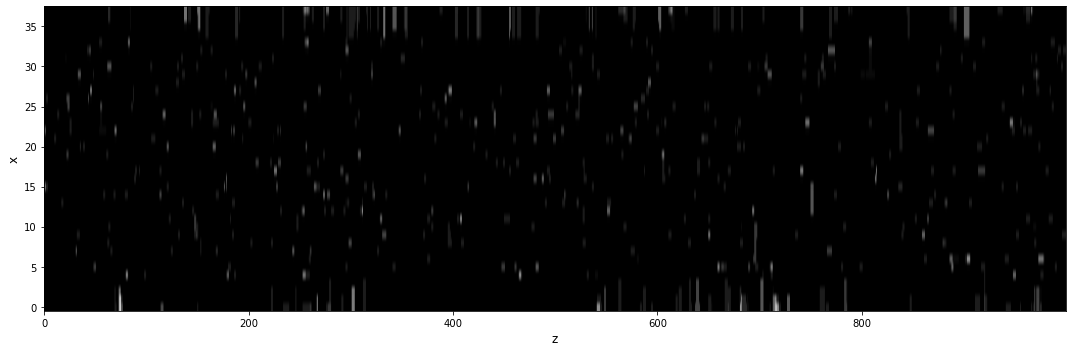

In [122]:
fig, ax0 = plt.subplots(1, figsize = (15, 5))

histxz, binx, binz = np.histogram2d(X, Z, bins = (test_image.shape[0] // step_size, 1000))
ax0.imshow(histxz, origin = "lower", aspect='auto', cmap='gist_gray')
ax0.set_xlabel("z", fontsize = 12)
ax0.set_ylabel("x", fontsize = 12)
plt.tight_layout()

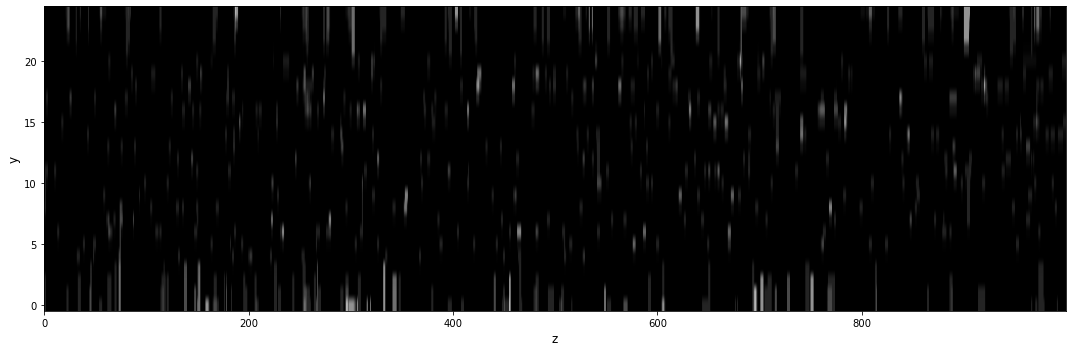

In [123]:
fig, ax0 = plt.subplots(1, figsize = (15, 5))

histyz, biny, binz = np.histogram2d(Y, Z, bins = (test_image.shape[1] // step_size, 1000))
ax0.imshow(histyz, origin = "lower", aspect='auto', cmap='gist_gray')
ax0.set_xlabel("z", fontsize = 12)
ax0.set_ylabel("y", fontsize = 12)
plt.tight_layout()

### Make a similar plot but on the smaller grid

In [47]:
sx = test_image.shape[0] // step_size
sy = test_image.shape[1] // step_size

In [48]:
def process_one_plane(z_idx):
    
    x, y, z = [], [], []
    xt, yt, zt = [], [], []
    dice = []
    
    true_arr = np.zeros((sx, sy))
    pred_arr = np.zeros((sx, sy))
    
    pred_prob = load_sparse_csr(f"images/prob_{z_idx}")
    pred_label = load_sparse_csr(f"images/pred_{z_idx}")
    true_label = load_sparse_csr(f"images/true_{z_idx}")
    
    for row_idx in range(sx):

        if row_idx*step_size+tile_size > true_label.shape[0]:
            image_pixel_x = true_label.shape[0]-tile_size
            row_slice = slice(-tile_size,None)
            row_break = True
        else:
            image_pixel_x = row_idx*step_size
            row_slice = slice(row_idx*step_size,row_idx*step_size+tile_size)
            row_break = False

        for col_idx in range(sy):

            if col_idx*step_size+tile_size > true_label.shape[1]:
                image_pixel_y = true_label.shape[1]-tile_size
                col_slice = slice(-tile_size,None)
                col_break = True
            else:
                image_pixel_y = col_idx*step_size
                col_slice = slice(col_idx*step_size,col_idx*step_size+tile_size)
                col_break = False

            max_label = np.amax(pred_label[row_slice, col_slice])
            max_probs = np.amax(pred_prob[row_slice, col_slice])
            max_truth = np.amax(true_label[row_slice, col_slice])
            
            true_arr[row_idx, col_idx] = max_truth
            pred_arr[row_idx, col_idx] = max_label
            
            dice_tile = dice_coef2(
                true_label[row_slice, col_slice].toarray(),
                pred_label[row_slice, col_slice].toarray()
            )
            dice.append(dice_tile)
            
            if max_label == 1.0:
                x.append(row_idx)
                y.append(col_idx)
                z.append(z_idx)
            
            if max_truth == 1.0:
                xt.append(row_idx)
                yt.append(col_idx)
                zt.append(z_idx)

            if col_break: 
                break

        if row_break:
            break
            

    results = {
        "preds": [x, y, z],
        "truths": [xt, yt, zt],
        "metrics": [dice]
    }
    
    return results

In [54]:
x, y, z = [], [], []
xt, yt, zt = [], [], []
dice = []

max_planes = 1000

ncpus = 8
with mp.Pool(ncpus) as p:
    
    for results in tqdm.tqdm(p.imap(process_one_plane, z_file_indices[:max_planes]), total = max_planes):
        
        x += results["preds"][0]
        y += results["preds"][1]
        z += results["preds"][2]

        xt += results["truths"][0]
        yt += results["truths"][1]
        zt += results["truths"][2]
        
        dice += results["metrics"][0]

100%|██████████| 1000/1000 [08:03<00:00,  2.07it/s]


In [124]:
print(np.mean(dice))

(14072.0, 157928.0)

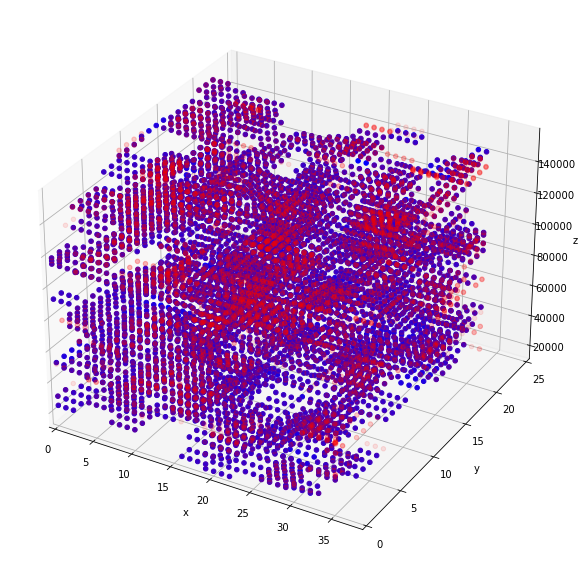

In [60]:
fig = plt.figure(figsize = (10, 20))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, c = "r", alpha = 0.1, zorder = 1, marker = 'o') 
ax.scatter3D(xt, yt, zt, c = 'b', alpha = 1.0, zorder = 2, marker = 'o')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim([0, sx])
ax.set_ylim([0, sy])
ax.set_zlim([z_file_indices[0], z_file_indices[max_planes-1]])

### How to visualize results better?

### Compute other useful binary metrics

### Compute the ROC curve